In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def pick_random_list(l):
    return l[np.random.randint(0,len(l))]

In [3]:
def pick_random(X, n = 1):
    return X[np.random.randint(0,len(X), n)]

In [4]:
# Build an MAAE (no length fixed)
def build_maae(l_max = 100, d = 2):
    m, p = [[0]*d], 1.0
    directions = np.concatenate((np.identity(d), -np.identity(d))).astype(np.int8)
    for l in range(l_max):
        last_pos = m[len(m) - 1]
        new_pos = last_pos + directions
        
        # Checking position
        pos_available = []
        for pos in new_pos.tolist():
            if pos not in m:
                pos_available.append(pos)
        
        #Handling proba
        n_pos = len(pos_available)
        if (n_pos == 0):
            break
        else:
            p *= n_pos/len(directions)
        
        # Picking random one
        next_pos = pick_random_list(pos_available)
        m.append(next_pos)
    
    return np.array(m), p

In [5]:
# Build an MAAE with a fixed length
def build_maae_l(l, d = 2, iter_max=1000):
    for i in range(iter_max):
        m, p = build_maae(l_max = l, d = d)
        if (len(m) == l+1):
            return m, p, 1/(i+1)
    raise ValueError(str(l) + " length is too far to reach in " + str(d) +" dimension. ("+str(iter_max)+" iterations)")

In [6]:
# Give the euclidian distance of a MA
def dist(m):
    return np.linalg.norm(m[0]-m[len(m) - 1])

In [7]:
# Plot an MA
def plot(m):
    plt.figure()
    plt.grid()
    plt.axis("equal")
    plt.plot(m[:,0], m[:,1])

In [8]:
# Mean distance estimators
def mean_d(l, n = 10000):
    D = np.zeros(n)
    for i in range(n):
        m, p, accept_rate = build_maae_l(l)
        D[i] = dist(m)/p
    return D.mean()/D.std()

<IPython.core.display.Javascript object>


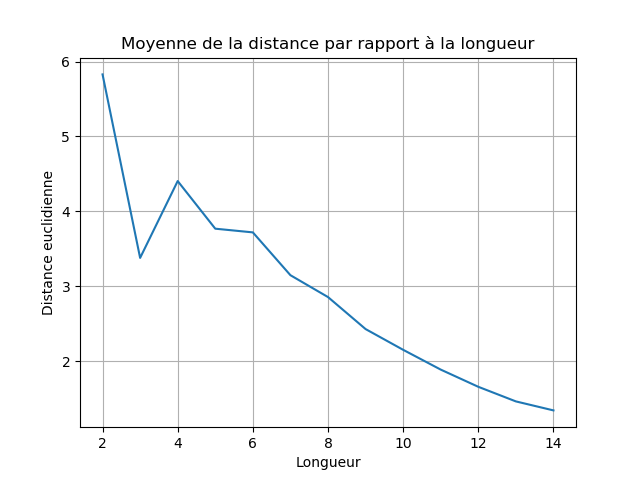

Text(0.5,1,'Moyenne de la distance par rapport à la longueur')

In [9]:
L = range(2,15)
D = []
for l in L:
    D.append(mean_d(l))
    
plt.figure()
plt.grid()
plt.plot(L, D)
plt.xlabel("Longueur")
plt.ylabel("Distance euclidienne")
plt.title("Moyenne de la distance par rapport à la longueur")